In [1]:
# Import general python packages used by scientists
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gc
import os
import pandas as pd

# Import packages  Image Access
import lsst.daf.butler as dafButler
import lsst.geom as geom
from lsst.geom import PointD
from lsst.geom import Point2D
import lsst.afw.display as afwDisplay
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius
from lsst.afw import cameraGeom

# Import packages for  Catalog Access
import pandas
pandas.set_option('display.max_rows', 1000)
from lsst.rsp import get_tap_service, retrieve_query

#Import custom packages
from ellipticity_mapping import calculate_ellipticity_on_xy
from collection_dictionary_shared import collection_dictionary

from datetime import datetime, timedelta
from astroplan import Observer
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from pytz import all_timezones #To visualize all the possible timezones
from pytz import timezone
import datetime
import time

In [2]:
timestamp = time.time()  # Example timestamp
datetime_object = datetime.datetime.fromtimestamp(timestamp)
formatted_datetime = datetime_object.strftime("%Y%m%dT%H%M%S")

In [3]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector
    
def pixel_to_focal(x, y, det):
    """
    Parameters
    ----------
    x, y : array
        Pixel coordinates.
    det : lsst.afw.cameraGeom.Detector
        Detector of interest.
    Returns
    -------
    fpx, fpy : array
        Focal plane position in millimeters in DVCS
        See https://lse-349.lsst.io/
    """
    tx = det.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    fpx, fpy = tx.getMapping().applyForward(np.vstack((x, y)))
    return fpx.ravel(), fpy.ravel()

def pixel_to_focal_angle(x, y, det):
    """
    Parameters
    ----------
    x, y : array
        Pixel coordinates.
    det : lsst.afw.cameraGeom.Detector
        Detector of interest.
    Returns
    -------
    fpx, fpy : array
        Focal plane position in degrees in DVCS
        See https://lse-349.lsst.io/
    """
    tx = det.getTransform(cameraGeom.PIXELS, cameraGeom.FIELD_ANGLE)
    fpx, fpy = tx.getMapping().applyForward(np.vstack((x, y)))
    return np.degrees(fpx.ravel()), np.degrees(fpy.ravel())

In [4]:
print("potrei leggere queste cose da yaml???")
# seqnums = [36, 37, 38, 39, 40, 41, 42, 43, 44]
seqnums = [83, 84, 85, 86]
# detectors = [165, 178, 185, 124, 132, 142, 152, 160, 75, 84, 94, 104, 113, 26, 36, 46, 56, 64, 3, 10, 23]
# detectors = [168, 178, 188, 123, 132, 142, 152, 161, 75, 84, 94, 104, 113, 27, 36, 46, 56, 65, 0, 10, 20]
# detectors = list(np.arange(189))
detectors = [36, 56, 143]
format_figures = 'png'

potrei leggere queste cose da yaml???


In [5]:
collection_dict = collection_dictionary()

In [6]:
folder = '/sdf/data/rubin/shared/image_quality/imsim/'
#Define the butler data configuration and collection (una tantum )
config = folder+'repo'
folderout = folder+'ellipticitymap/'
subfolderout_fig = 'figures/'
subfolderout_tab = 'tables/'

In [7]:
# Saves to a file the information (seqnum, detector and collection) 
# associated to each run of this notebook and each output file
filedict = open(folderout+'mean_ellipticity_dictionary', 'a')  # append mode

for seq in seqnums:
    for det in detectors:
        collection = collection_dict[seq]
        filedict.write('{:s} {:d} {:d} {:s}\n'.format('mean_ellipticities_'+formatted_datetime+'.csv', 
                                                 seq, det, collection))

filedict.close()

83 36
178.743458672946
3.119661870245322


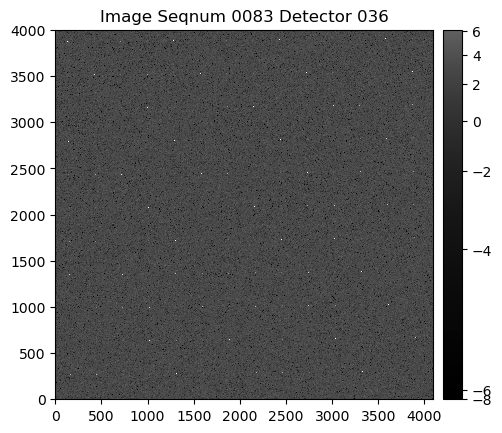

83 56
178.743458672946
3.119661870245322


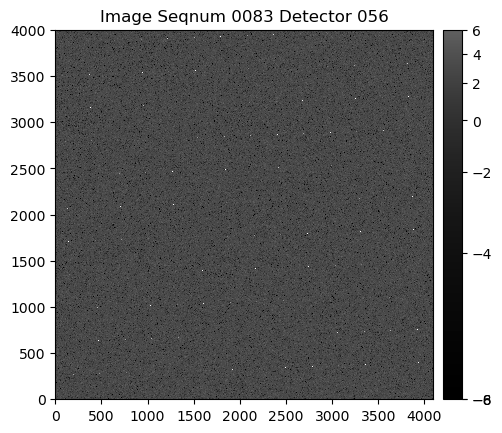

83 143
178.743458672946
3.119661870245322


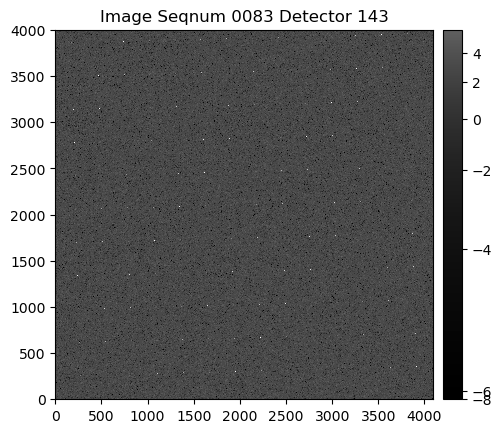

84 36
148.743458672945
2.596063094647006


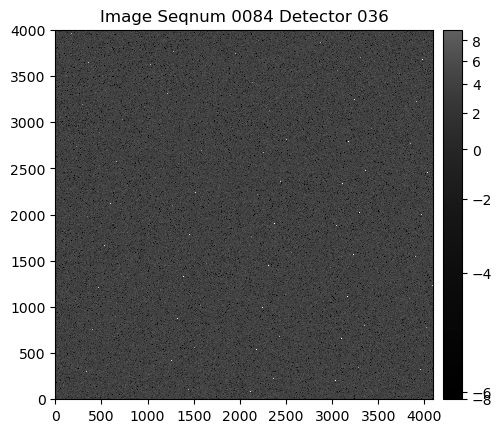

84 56
148.743458672945
2.596063094647006


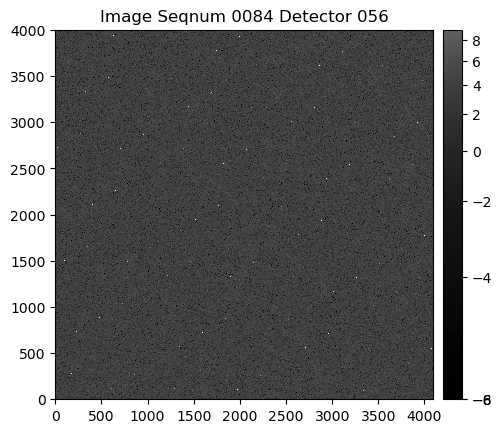

84 143
148.743458672945
2.596063094647006


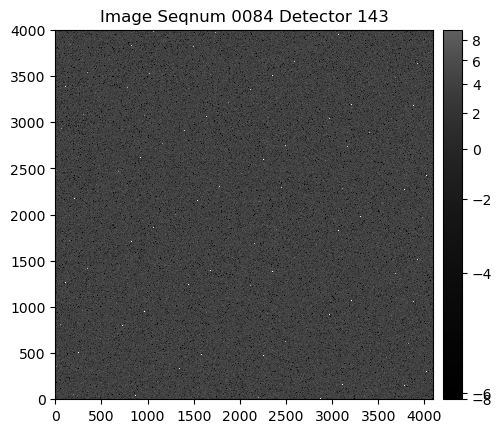

85 36
118.743458672945
2.0724643190487066


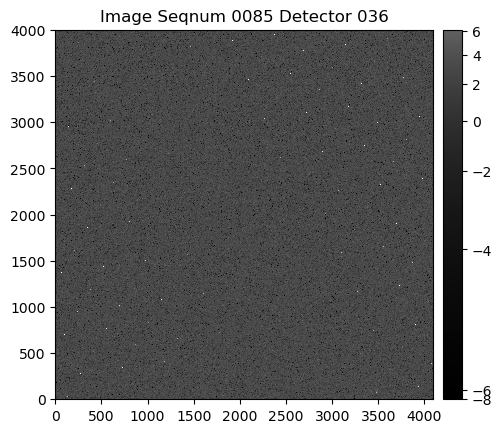

85 56
118.743458672945
2.0724643190487066


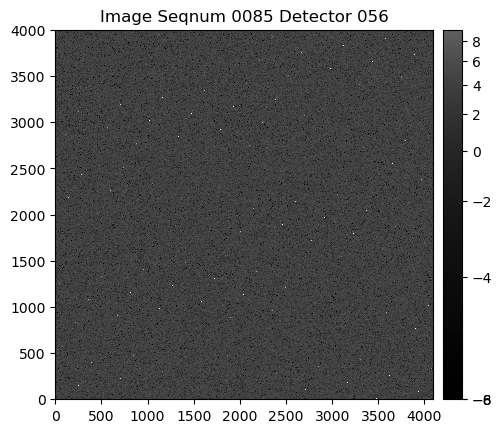

85 143
118.743458672945
2.0724643190487066


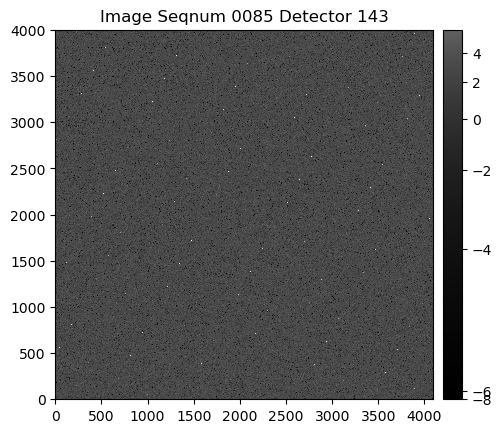

86 36
88.7434586729451
1.5488655434504095


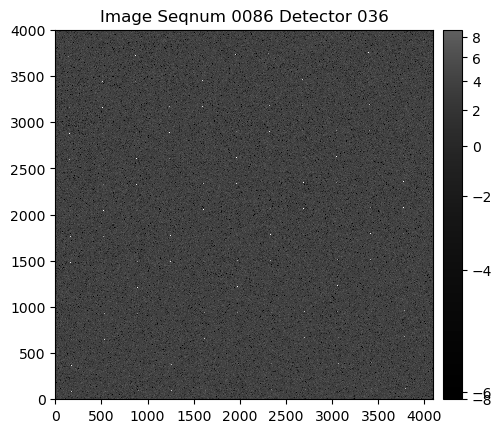

86 56
88.7434586729451
1.5488655434504095


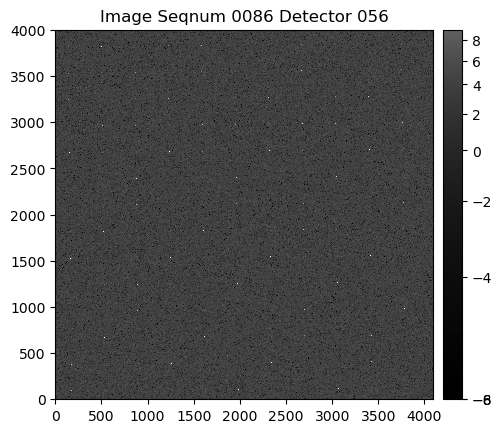

86 143
88.7434586729451
1.5488655434504095


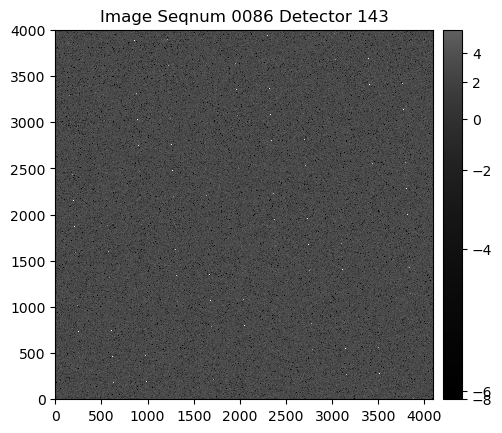

Le rotazioni sono sbagliate perchè fatte detector per detector e non sul piano focale!!!!


In [8]:
do_make_figures_calexp = True
do_make_ellipticity_in_the_center = True
do_make_mean_ellipticity = True
do_ellipticity_on_focalplane = True
regular_grid_or_star_positions = 1 # parametro per l'ellitticità su singolo detector 0: calcolo e su griglia; 1: calcolo e su posizioni stelle
n_grid = 3

do_figure_wcs = False
do_figure_bkg = False
do_figure_psf = False

# OUTPUT ELLITTICITÀ MEDIE SUI DETECTOR
detector_output = []
seqnum_output = []
mean_e_output = []
median_e_output = []
std_e_output = []
min_e_output = []
max_e_output = []
xx_mean_output = []
yy_mean_output = []
xx_mm_output = []
yy_mm_output = []

x_centro_detector = 2000.
y_centro_detector = 2000.

for seqnum in seqnums:

    # output di tabella di ellitticità (puntuale) sul focalplane
    e_output_fp = []
    ex_output_fp = []
    ey_output_fp = []
    ex_rot_output_fp = []
    ey_rot_output_fp = []
    theta_output_fp = []
    xx_output_fp = [] #coordinate x su detector
    yy_output_fp = [] #coordinate x su detector
    xx_mm_output_fp = [] #coordinate x su focal plane
    yy_mm_output_fp = [] #coordinate y su focal plane
    seqnum_output_fp = []
    detector_output_fp = []
    
# PER ORA COMMENTATO!!!!!! SERVE PER CALCOLARE LE ELLITTICITÀ SU GRIGLIE INTERNE AI DETECTOR NEI FOCALPLANE    
    # e_all_to_reshape = []
    # ex_all_to_reshape = []
    # ey_all_to_reshape = []
    # ex_all_rot_to_reshape = []
    # ey_all_rot_to_reshape = []
    # theta_all_to_reshape = []
    # xx_to_reshape = [] #coordinate x su detector
    # yy_to_reshape = [] #coordinate x su detector
    # xx_mm_to_reshape = [] #coordinate x su focal plane
    # yy_mm_to_reshape = [] #coordinate y su focal plane
    
    for detector in detectors:
        
        visit_seqnum = 5023071800000 + seqnum
        
        print(seqnum, detector)

        collection = collection_dict[seqnum]

        # Create the butler
        butler = dafButler.Butler(config,collections=collection)

        #Adesso dobbiammo dire al butler che tipo di dati vogliamo.
        #La call si fa chiedendo un datasetType (e.g., deepCoadd, calexp, objectTable) e un data ID(is a dictionary-like identifier for a specific data product)
        #Qui piu' informazioni sul butler 
        #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04b_Intermediate_Butler_Queries.ipynb

        datasetType='calexp'
        dataId = {'visit': visit_seqnum, 'detector': detector, 'band':'r'}
        calexp = butler.get(datasetType, **dataId)
        sources = butler.get('src', dataId)
        psf = calexp.getPsf()
        bkgd = butler.get('calexpBackground', **dataId)
        ccd = calexp.detector.getId()
        det = calexp.getDetector()
        wcs = calexp.getWcs()
        calexp_info = calexp.getInfo()

        # rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()
        
        # Ixx_from_source = sources['ext_shapeHSM_HsmPsfMoments_xx']
        # Ixy_from_source = sources['ext_shapeHSM_HsmPsfMoments_xy']
        # Iyy_from_source = sources['ext_shapeHSM_HsmPsfMoments_yy']
        # theta_from_source = np.arctan2(2. * Ixy_from_source, Ixx_from_source - Iyy_from_source) / 2.
        # e1_from_source = (Ixx_from_source - Iyy_from_source) / (Ixx_from_source + Iyy_from_source)
        # e2_from_source = (2. * Ixy_from_source) / (Ixx_from_source + Iyy_from_source)
        # e_from_source = np.sqrt(e1_from_source**2 + e2_from_source**2)
        # ex_from_source = e_from_source * np.cos(theta_from_source)
        # ey_from_source = e_from_source * np.sin(theta_from_source)
        # theta_fp_from_source = np.arctan2(ex_from_source, ey_from_source) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
        # ex_rot_from_source = ex_from_source*np.cos(np.radians(rot)) - ey_from_source*np.sin(np.radians(rot))
        # ey_rot_from_source = ex_from_source*np.sin(np.radians(rot)) + ey_from_source*np.cos(np.radians(rot))
        
        # xx = [l.getCentroid()[0] for l in sources]
        # yy = [l.getCentroid()[1] for l in sources]        
        # points = []
        # coos = []
        # for x_temp, y_temp in zip(xx, yy):
        #     coo = wcs.pixelToSky(x_temp, y_temp)
        #     point = geom.Point2D(x_temp, y_temp)
        #     points.append(point)
        #     coos.append(coo)

        # fpxys = [pixel_to_focal_angle(p[0], p[1], det) for p in points]
        # fpxs = [x[0] for x in fpxys]
        # fpys = [x[1] for x in fpxys]
        
        # Ixxs = [psf.computeShape(point).getIxx() for point in points]
        # Iyys = [psf.computeShape(point).getIyy() for point in points]
        # Ixys = [psf.computeShape(point).getIxy() for point in points]        

        # Ixxs = np.asarray(Ixxs)
        # Iyys = np.asarray(Iyys)
        # Ixys = np.asarray(Ixys)
        
        # theta = np.arctan2(2. * Ixys, Ixxs - Iyys) / 2.
        # e1 = (Ixxs - Iyys) / (Ixxs + Iyys)
        # e2 = (2. * Ixys) / (Ixxs + Iyys)
        # e = np.sqrt(e1**2 + e2**2)
        # ex = e * np.cos(theta)
        # ey = e * np.sin(theta)
        # theta_fp = np.arctan2(ex, ey) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
        # ex_rot = ex*np.cos(np.radians(rot)) - ey*np.sin(np.radians(rot))
        # ey_rot = ex*np.sin(np.radians(rot)) + ey*np.cos(np.radians(rot))

        # fig = plt.figure(figsize=(8, 6))
        # ax1 = fig.add_subplot(211)
        # ax2 = fig.add_subplot(212)
        # ax1.quiver(xx, yy, ex, ey, headlength=0., color='k', headwidth=1., pivot='mid', width=0.005, alpha=.4)
        # ax2.quiver(xx, yy, ex_from_source, ey_from_source, color='r', headlength=0., headwidth=1., pivot='mid', width=0.005, alpha=.4)
        # # colorbar = plt.colorbar(label='e')
        # # plt.clim(0., max(e))
        # plt.xlabel('x')
        # plt.ylabel('y')
        # plt.title('Ellipticity Sticks')
        # fig.savefig(folderout+"figures/Ellipticity_Sticks_seqnum{:04d}_det{:03d}.{:s}".format(seqnum,detector,format_figures))
        # remove_figure(fig)
        
        # assert False
        
        if do_ellipticity_on_focalplane:

        # In questa sezione, si calcola e nel pixel centrale e si crea la griglia xx_mm e yy_mm sul focal plane
            rot = (calexp.info.getVisitInfo().getBoresightRotAngle()).asDegrees()
            print(rot)
            print(np.radians(rot))

            # Singolo punto per ogni detector
            coo = wcs.pixelToSky(x_centro_detector, y_centro_detector)
            point = geom.Point2D(x_centro_detector, y_centro_detector)

            fpx, fpy = pixel_to_focal_angle(point[0], point[1], det)
            Ixx = psf.computeShape(point).getIxx()
            Iyy = psf.computeShape(point).getIyy()
            Ixy = psf.computeShape(point).getIxy()
            theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
            e1 = (Ixx - Iyy) / (Ixx + Iyy)
            e2 = (2. * Ixy) / (Ixx + Iyy)
            e = np.sqrt(e1**2 + e2**2)
            ex = e * np.cos(theta)
            ey = e * np.sin(theta)
            theta_fp = np.arctan2(ex, ey) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
            ex_rot = ex*np.cos(np.radians(rot)) - ey*np.sin(np.radians(rot))
            ey_rot = ex*np.sin(np.radians(rot)) + ey*np.cos(np.radians(rot))
            
    #################################
    #    OUTPUT TABLE ELLIPTICITIES SU PUNTI SINGOLI
    #################################
            e_output_fp.append(e)
            ex_output_fp.append(ey) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
            ey_output_fp.append(ex) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
            ex_rot_output_fp.append(ey_rot) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
            ey_rot_output_fp.append(ex_rot) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
            theta_output_fp.append(theta_fp)
            xx_output_fp.append(coo[1].asDegrees()) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
            yy_output_fp.append(coo[0].asDegrees()) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
            xx_mm_output_fp.append(fpy[0]) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
            yy_mm_output_fp.append(fpx[0]) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
            seqnum_output_fp.append(seqnum)
            detector_output_fp.append(detector)

        #     # Griglia per ogni detector
        #     x_griglia = (4000./n_grid) * (np.arange(n_grid) + .5)
        #     y_griglia = x_griglia

        #     xy_griglia = list(zip(x_griglia, y_griglia))
        #     print(xy_griglia)
        #     coos = [wcs.pixelToSky(xy[0], xy[1]) for xy in xy_griglia]
        #     points = [geom.Point2D (xy[0], xy[1]) for xy in xy_griglia]
        #     fpxys = [pixel_to_focal_angle(p[0], p[1], det) for p in points]
        #     fpxs = [x[0] for x in fpxys]
        #     print('fpxs')
        #     print(fpxs)
        #     fpys = [x[1] for x in fpxys]
        #     Ixxs = [psf.computeShape(point).getIxx() for point in points] 
        #     Iyys = [psf.computeShape(point).getIyy() for point in points] 
        #     Ixys = [psf.computeShape(point).getIxy() for point in points] 
        #     Ixxs_array = np.asarray(Ixxs)
        #     Iyys_array = np.asarray(Iyys)
        #     Ixys_array = np.asarray(Ixys)
        #     thetas = np.arctan2(2. * Ixys_array, Ixxs_array - Ixxs_array) / 2.
        #     e1s = (Ixxs_array - Ixxs_array) / (Ixxs_array + Ixxs_array)
        #     e2s = (2. * Ixys_array) / (Ixxs_array + Ixxs_array)
        #     es = np.sqrt(e1s**2 + e2s**2)
        #     exs = es * np.cos(thetas)
        #     eys = es * np.sin(thetas)
        #     exs_rot = exs*np.cos(np.radians(rot)) - eys*np.sin(np.radians(rot))
        #     eys_rot = exs*np.sin(np.radians(rot)) + eys*np.cos(np.radians(rot))

        #     e_all_to_reshape.append(es)
        #     ex_all_to_reshape.append(exs)
        #     ey_all_to_reshape.append(eys)
        #     ex_all_rot_to_reshape.append(exs_rot)
        #     ey_all_rot_to_reshape.append(eys_rot)
        #     xx_to_reshape.append([coo[0].asDegrees() for coo in coos])
        #     yy_to_reshape.append([coo[1].asDegrees() for coo in coos])
        #     xx_mm_to_reshape.append([fpx[0] for fpx in fpxs])
        #     yy_mm_to_reshape.append([fpy[0] for fpy in fpys])
            
        # xx_mm = np.ravel(xx_mm_to_reshape)
        
            # for x_temp in x_griglia:
            #     for y_temp in y_griglia:
            #         coo = wcs.pixelToSky(x_temp, y_temp)
            #         point = geom.Point2D(x_temp, y_temp)
                    
            #         fpx, fpy = pixel_to_focal_angle(point[0], point[1], det)
            #         Ixx = psf.computeShape(point).getIxx()
            #         Iyy = psf.computeShape(point).getIyy()
            #         Ixy = psf.computeShape(point).getIxy()
            #         theta = np.arctan2(2. * Ixy, Ixx - Iyy) / 2.
            #         #theta.append(np.arctan2(2. * Ixy, Ixx - Iyy) / 2.)
            #         e1 = (Ixx - Iyy) / (Ixx + Iyy)
            #         e2 = (2. * Ixy) / (Ixx + Iyy)
            #         e = np.sqrt(e1**2 + e2**2)
            #         ex = e * np.cos(theta)
            #         ey = e * np.sin(theta)
            #         ex_rot = ex*np.cos(np.radians(rot)) - ey*np.sin(np.radians(rot))
            #         ey_rot = ex*np.sin(np.radians(rot)) + ey*np.cos(np.radians(rot))
            #         e_all.append(e)
            #         ex_all.append(ex)
            #         ey_all.append(ey)
            #         ex_all_rot.append(ex_rot)
            #         ey_all_rot.append(ey_rot)
            #         xx.append(coo[0].asDegrees())
            #         yy.append(coo[1].asDegrees())
            #         xx_mm.append(fpx[0])
            #         yy_mm.append(fpy[0])
        
        if do_make_figures_calexp:
    #################################        
    # Display figures (inizio)
    #################################        

            # create a matplotlib.pyplot figure
            fig = plt.figure()
            #Display the image with lsst.afw.display

            #The next task is to let AFWDisplay know that we want it to use matplotlib as our default display backend.
            #To do this, we use the setDefaultBackend() function. Remember that we made an alias to lsst.afw.display called afwDisplay in the import
            afwDisplay.setDefaultBackend('matplotlib')
            # get an alias to the lsst.afw.display.Display() method
            display = afwDisplay.Display(frame=fig)
            # set the image stretch algorithm and range
            display.scale('asinh', 'zscale')
            # load the image into the display
            display.mtv(calexp.image)
            # show the corresponding pyplot figure
            plt.title("Image Seqnum {:04d} Detector {:03d}".format(seqnum,detector))
            plt.show()
            # clean up memory
            remove_figure(fig)

            #Esiste un tutorial per l'utilizzo di  afw_display che il numero 3 del tutorial, da studiare perche' questo e' lo standard, 
            #in particolare fornisce funzioi su come fare i cut, le composizioni di immagini  etc...)
            #https://github.com/rubin-dp0/tutorial-notebooks/blob/main/03a_Image_Display_and_Manipulation.ipynb

            #invece il noteook dopo va su strumenti un po' piu' potenti di data display come firefly che ti apre figure iterattive che credo sia il caso di imparare

            if do_figure_wcs:
                #Figura con WCS
                fig = plt.figure()
                plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
                calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
                                 calexp.getBBox().beginY, calexp.getBBox().endY)
                im = plt.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400,
                                extent=calexp_extent, origin='lower')
                plt.grid(color='white', ls='solid')
                plt.xlabel('Right Ascension')
                plt.ylabel('Declination')
                plt.show()
                remove_figure(fig)

            if do_figure_psf:
                #EXPLORE PSF
                #The PSF object can be used to get a realization of a PSF at a specific point
                fig = plt.figure()
                psfimage = psf.computeImage(PointD(x_centro_detector, y_centro_detector))
                display = afwDisplay.Display()
                display.scale('asinh', min=0.0, max=1.e-3, unit='absolute')
                display.mtv(psfimage)
                plt.title("PSF at 2000 2000 Seqnum {:04d} Detector {:03d}".format(seqnum,detector))
                plt.show()
                remove_figure(fig)

            #Visualize
            afwDisplay.setDefaultBackend('matplotlib')

            if do_figure_bkg:
                fig = plt.figure()
                afw_display = afwDisplay.Display()
                afw_display.scale('linear', 'zscale')
                afw_display.mtv(bkgd.getImage())
                plt.title("Local Polynomial Background Seqnum {:04d} Detector {:03d}".format(seqnum,detector))
                plt.show()
                # remove_figure(fig)
            # assert False
        
    #################################        
    #Display figures (FINE)
    #################################        

    #################################        
    # Ellipticity on grid su singolo detector (inizio)
    #################################        
        n_grid = 200
        # Calcolo e salva anche la griglia
        fileout = 'ellipticitymap_seqnum{:04d}_det{:03d}.csv'.format(seqnum, detector)
        e, ex, ey, ex_rot, ey_rot, e1, e2, xx, yy, theta, fwhm, size = \
            calculate_ellipticity_on_xy(calexp, sources, psf, regular_grid_or_star_positions, n_grid,
                                       fileout=folderout+subfolderout_tab+fileout)

        # Statistica sulle ellitticità
        mean_e = np.mean(e)
        median_e = np.median(e)
        std_e = np.std(e)
        min_e = min(e)
        max_e = max(e)

### plotto la figura con gli ellipticity sticks sulla griglia nel detector            
        fig = plt.figure(figsize=(8, 6))
        plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.005)
        colorbar = plt.colorbar(label='e')
        plt.clim(0., max(e))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Ellipticity Sticks')
        fig.savefig(folderout+"figures/Ellipticity_Sticks_seqnum{:04d}_det{:03d}.{:s}".format(seqnum,detector,format_figures))
        remove_figure(fig)
    #################################        
    # Ellipticity on grid su singolo detector (fine)
    #################################

    #################################
    #    OUTPUT TABLE MEAN ELLIPTICITIES
    #################################
        detector_output.append(detector)
        seqnum_output.append(seqnum)
        mean_e_output.append(mean_e)
        median_e_output.append(median_e)
        std_e_output.append(std_e)
        min_e_output.append(min_e)
        max_e_output.append(max_e)
        point = geom.Point2D(x_centro_detector, y_centro_detector)
        fpx, fpy = pixel_to_focal_angle(point[0], point[1], det)
        xx_mm_output.append(fpy[0]) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP
        yy_mm_output.append(fpx[0]) #IMPORTANTE INVERTIRE XY TRA DETECTOR E FP

    if do_ellipticity_on_focalplane:
        fig = plt.figure(figsize=(10,8))
        plt.quiver(xx_mm_output_fp, yy_mm_output_fp, ex_output_fp, ey_output_fp, e_output_fp,  
           scale=.5, headlength=0., headwidth=1., pivot='mid', linewidths=.01)

        # plt.quiver(xx_mm_output_fp, yy_mm_output_fp, ex_rot_output_fp, ey_rot_output_fp, e_output_fp,  
        #    scale=.5, headlength=0., headwidth=1., pivot='mid', linewidths=.01)

        # ANNOTA CON I NUMERI DEI DETECTOR
        # for i, ddd in enumerate(detector_output_fp):
        #     plt.annotate(ddd, (yy_mm_output_fp[i], xx_mm_output_fp[i]))
        
        colorbar = plt.colorbar(label='ellipticity')
        # plt.clim(0., max(e_output_fp))
        plt.clim(0., 0.12)
        plt.xlabel('x [deg]')
        plt.ylabel('y [deg]')
        plt.title('Ellipticity Sticks')
        fig.savefig(folderout+"figures/Ellipticity_Sticks_focalplane_seqnum{:04d}.{:s}".format(seqnum,format_figures))
        remove_figure(fig)        

    # TABELLA ELLITTICITÀ PUNTUALI SU FOCALPLANE
    df = pd.DataFrame(data={'detector': detector_output_fp, 'seqnum': seqnum_output_fp, 
                            'xx_fp_deg': xx_mm_output_fp, 'yy_fp_deg': yy_mm_output_fp, 
                            'e': e_output_fp, 'ex': ex_output_fp, 'ey': ey_output_fp, 
                            'ex_rot': ex_rot_output_fp, 'ey_rot': ey_rot_output_fp, 
                            'theta': theta_output_fp})
    df.to_csv(folderout+subfolderout_tab+'ellipticities_focalplane_seqnum{:04d}.csv'.format(seqnum), index=False)

# TABELLA ELLITTICITÀ MEDIE SU FOCALPLANE
df = pd.DataFrame(data={'detector': detector_output, 'seqnum': seqnum_output, 
                        'xx_fp_deg': xx_mm_output, 'yy_fp_deg': yy_mm_output, 
                        'mean_e': mean_e_output, 'median_e': median_e_output, 
                        'std_e': std_e_output, 'min_e': min_e_output, 'max_e': max_e_output})
df.to_csv(folderout+subfolderout_tab+'mean_ellipticities_focalplane_'+formatted_datetime+'.csv', index=False)


print('Le rotazioni sono sbagliate perchè fatte detector per detector e non sul piano focale!!!!')

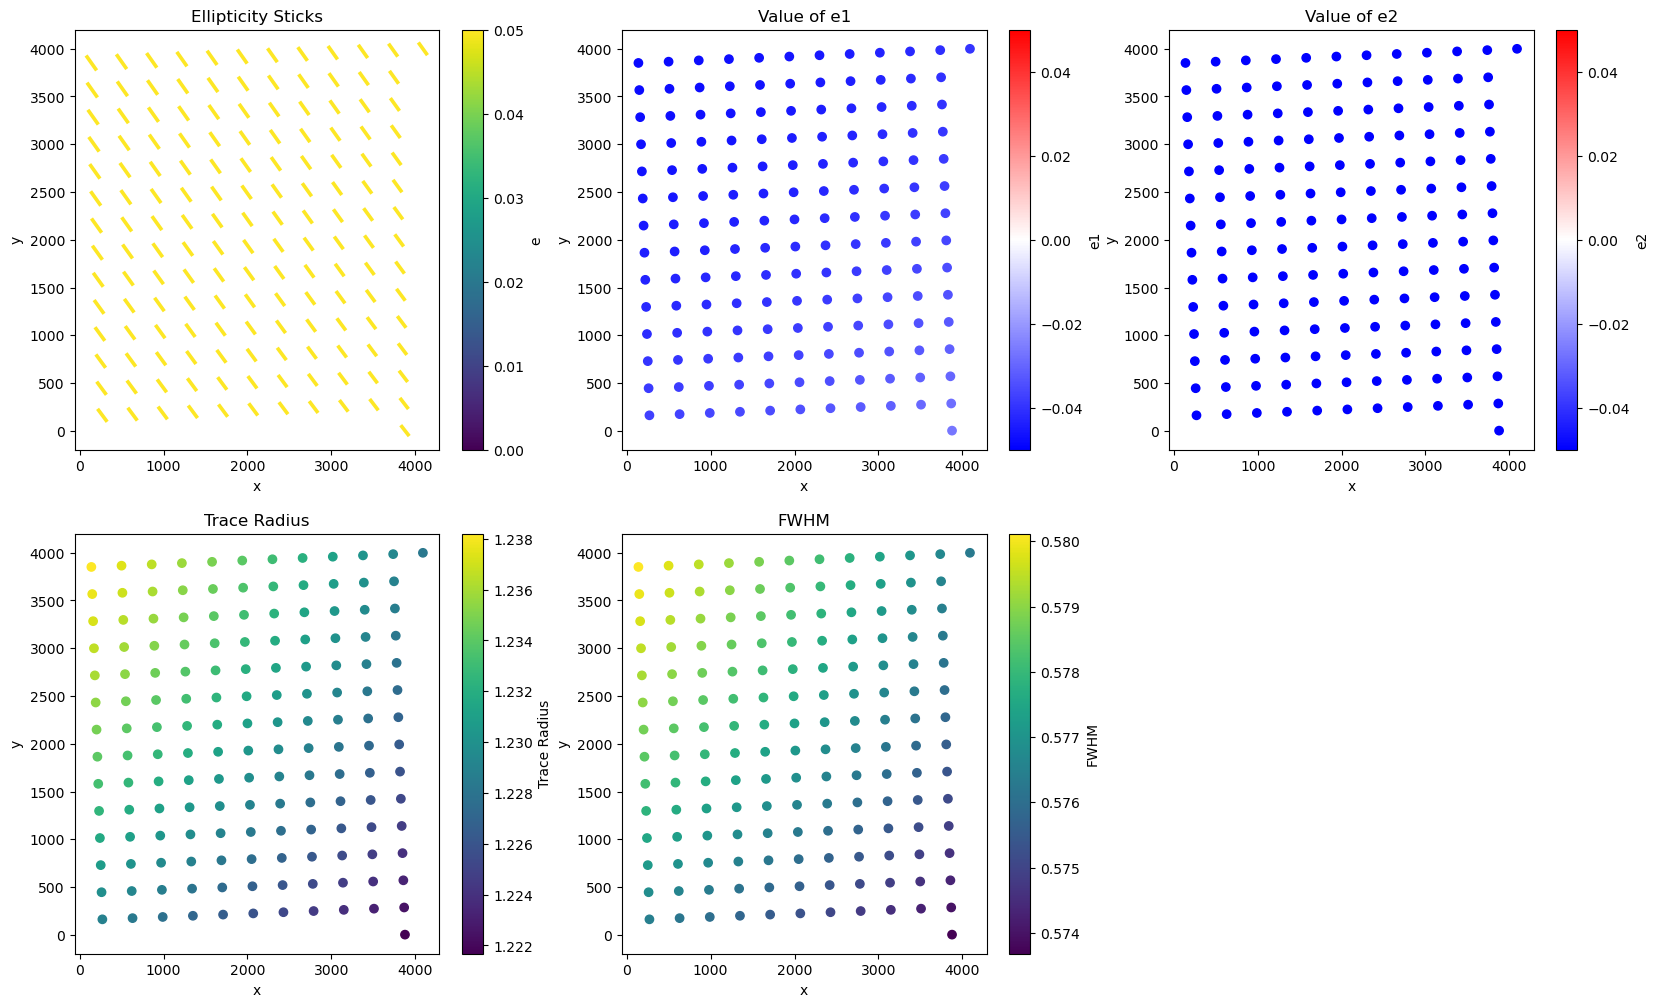

In [9]:
fig = plt.figure(figsize=(20, 12))
plt.subplots_adjust(wspace=0.2)

plt.subplot(2, 3, 1)
plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')

plt.subplot(2, 3, 2)
plt.scatter(xx, yy, c=e1, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Value of e1')

plt.subplot(2, 3, 3)
plt.scatter(xx, yy, c=e2, vmin=-0.05, vmax=0.05, cmap='bwr')
colorbar = plt.colorbar(label='e2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Value of e2')

plt.subplot(2, 3, 4)
plt.scatter(xx, yy, c=size)
colorbar = plt.colorbar(label='Trace Radius')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trace Radius');

plt.subplot(2, 3, 5)
plt.scatter(xx, yy, c=fwhm)
colorbar = plt.colorbar(label='FWHM')
plt.xlabel('x')
plt.ylabel('y')
plt.title('FWHM');

# fig.savefig(folderout+subfolderout_fig+'ellipticity_map_seqnum.pdf')

Text(0.5, 1.0, 'Ellipticity Sticks')

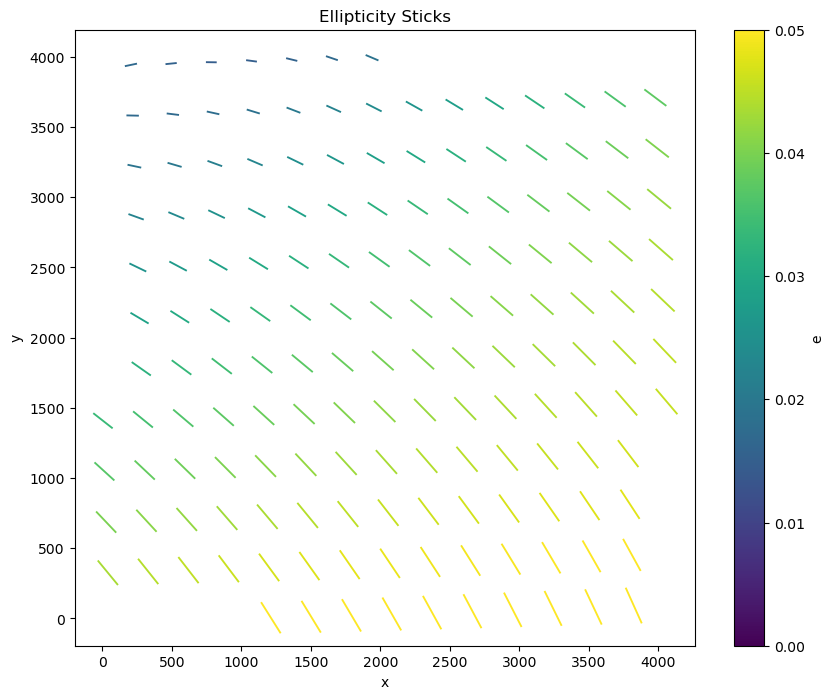

In [28]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.003)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')

Text(0.5, 1.0, 'Ellipticity Sticks')

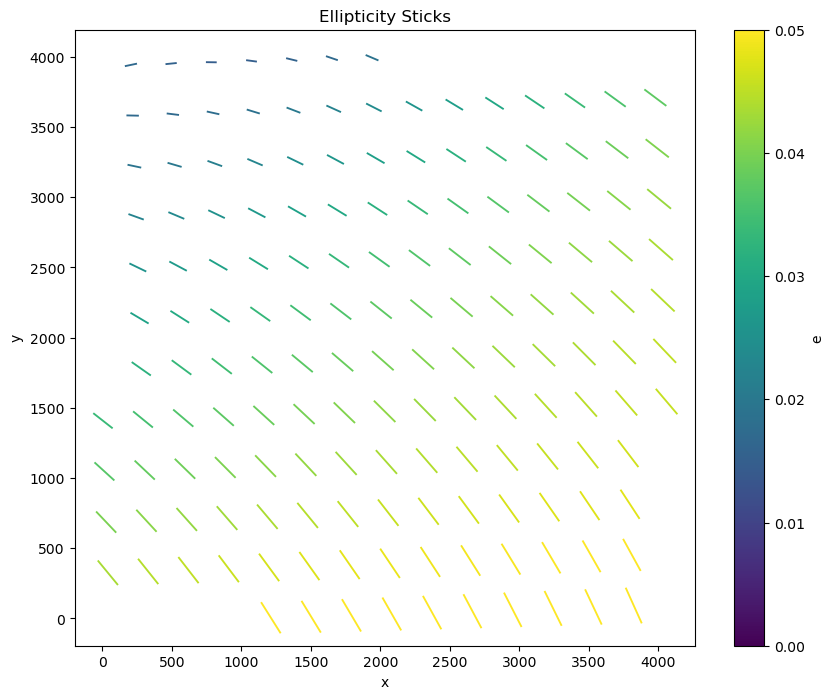

In [29]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=0.5)

plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.003)
#plt.quiver(xx, yy, scale=e, angles=phi, headlength=0., headwidth=1., pivot='mid', width=0.005)
#colorbar = plt.colorbar(label='r$\sqrt(e1^{2} + e2^{2})$')
colorbar = plt.colorbar(label='e')
plt.clim(0., 0.05)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipticity Sticks')